<ipython-input-2-63c45453f23b>:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.4 0.3 0.3 0.7 0.2 0.3 0.2 0.9 0.2 0.3 0.4 0.6 0.6 0.  0.1 0.4 0.7 0.4
 0.5 0.  0.7 0.5 0.5 0.6 0.3 0.3 0.3 0.7 0.3 0.4 0.3 0.2 0.  0.5 0.3 0.2
 0.4 0.4 0.5 0.2 0.6 0.2 0.2 0.2 0.6 0.6 0.6 0.4 0.7 0.2 0.6 0.3 0.5 0.7
 0.4 0.4 0.5 0.  0.7 0.  0.2 0.2 0.1 0.4 0.9 0.2 0.5 0.7 0.4 0.3 0.2 0.4
 0.2 0.2 0.8 0.4 0.2 0.  0.3 0.  0.5 0.6 0.2 0.8 0.2 0.4 0.6 0.4 0.1 0.6
 0.5 0.3 0.8 0.3 0.1 0.4 0.  0.7 0.7 0.5 0.7 0.7 0.4 0.7 0.5 0.4 0.4 0.6
 1.  0.  0.4 0.2 0.7 0.4 0.2 0.5 0.3 0.5 0.4 0.2 0.3 0.6 0.1 0.6 0.3 0.5
 0.5 0.1 0.2 0.  0.2 0.2 0.3 0.4 0.3 0.5 0.4 0.4 0.7 0.1 0.9 0.3 0.6 0.1
 0.7 0.3 0.8 0.4 0.4 0.  0.  0.4 0.5 0.5 0.6 1.  0.4 0.3 0.2 0.4 0.7 0.7
 0.5 0.4 0.8 0.3 0.2 0.3 0.5 0.4 0.4 0.5 0.7 0.4 0.9 0.2 0.3 0.3 0.5 0.5
 0.4 0.4 0.6 0.2 0.2 0.4 0.7 0.4 0.4 0.4 0.3 0.3 0.6 0.5 0.3 0.2 0.1 0.3
 0.4]' has dtype incompatible with int64, pl

Optimal Number of Clusters: {'n_clusters': 4, 'db_index': 0.43964185677535383}


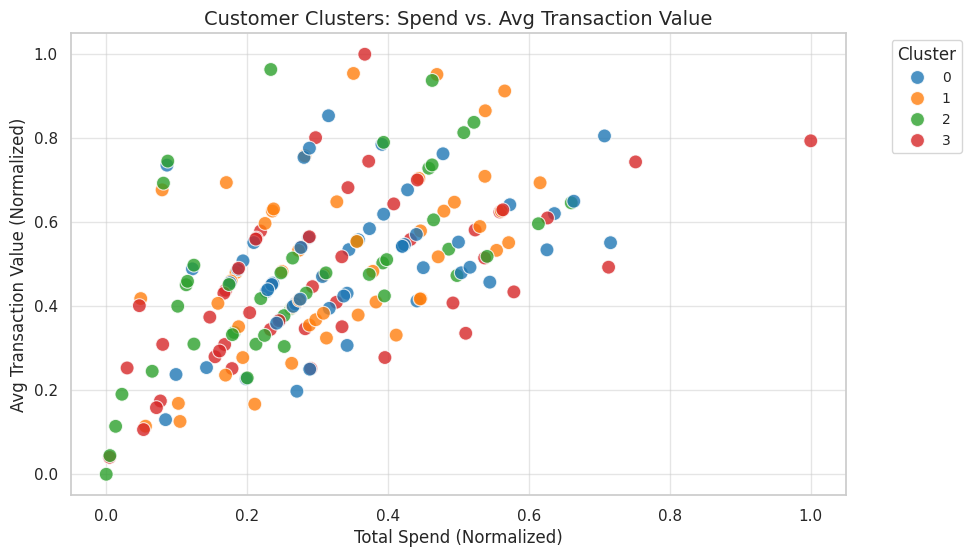

         avg_total_spend  avg_transaction_value  avg_transactions  count
Cluster                                                                 
0               0.346750               0.503466          0.440741     54
1               0.326921               0.504158          0.415686     51
2               0.280401               0.481704          0.329545     44
3               0.317271               0.459467          0.412000     50


In [2]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
# Loading the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merging transactions and products data
transactions_products = pd.merge(transactions_df, products_df, on='ProductID')
# Creating customer-level features
customer_features = transactions_products.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    total_transactions=('TransactionID', 'count')
).reset_index()

# Adding preferred category (highest spend per customer)
preferred_category = transactions_products.groupby(['CustomerID', 'Category'])['TotalValue'].sum().reset_index()
preferred_category = preferred_category.loc[preferred_category.groupby('CustomerID')['TotalValue'].idxmax()]
customer_features = customer_features.merge(preferred_category[['CustomerID', 'Category']], on='CustomerID')

# One-hot encoding preferred category
customer_features_encoded = pd.get_dummies(customer_features, columns=['Category'])
# Normalizing features for clustering
scaler = MinMaxScaler()
customer_features_encoded.iloc[:, 1:] = scaler.fit_transform(customer_features_encoded.iloc[:, 1:])
# Finding the optimal number of clusters using the Davies-Bouldin Index
cluster_results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(customer_features_encoded.iloc[:, 1:])
    db_index = davies_bouldin_score(customer_features_encoded.iloc[:, 1:], cluster_labels)
    cluster_results.append({'n_clusters': n_clusters, 'db_index': db_index})

# Finding the optimal number of clusters
optimal_clusters = min(cluster_results, key=lambda x: x['db_index'])
print(f'Optimal Number of Clusters: {optimal_clusters}')
# Applying KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters['n_clusters'], random_state=42, n_init=10)
customer_features_encoded['Cluster'] = kmeans.fit_predict(customer_features_encoded.iloc[:, 1:])

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features_encoded['total_spend'],
    y=customer_features_encoded['avg_transaction_value'],
    hue=customer_features_encoded['Cluster'],
    palette='tab10', s=100, alpha=0.8
)
plt.title('Customer Clusters: Spend vs. Avg Transaction Value', fontsize=14)
plt.xlabel('Total Spend (Normalized)', fontsize=12)
plt.ylabel('Avg Transaction Value (Normalized)', fontsize=12)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.5)
plt.show()
# Summarizing cluster characteristics
cluster_summary = customer_features_encoded.groupby('Cluster').agg(
    avg_total_spend=('total_spend', 'mean'),
    avg_transaction_value=('avg_transaction_value', 'mean'),
    avg_transactions=('total_transactions', 'mean'),
    count=('Cluster', 'size')
)
print(cluster_summary)